In [1]:
# RUN ONLY ONCE
# If by accident you ran this more than once then restart the kernel
from pathlib import Path
import os
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

In [2]:
import pandas as pd
import numpy as np
import locale
from locale import atof
import matplotlib.pyplot as plt
locale.setlocale(locale.LC_NUMERIC, '')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
pd.set_option('display.max_rows', 200)
from sklearn.impute import KNNImputer
from tqdm import tqdm

# Data Loading and Preproccessing

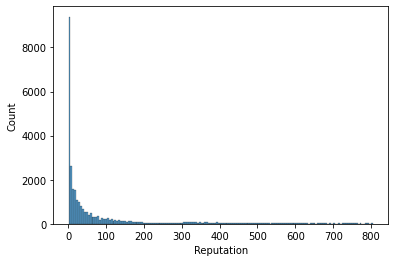

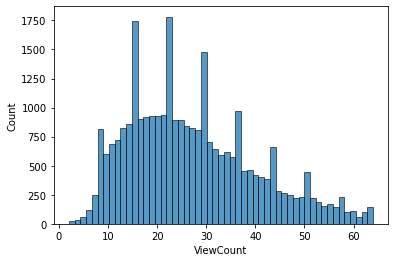

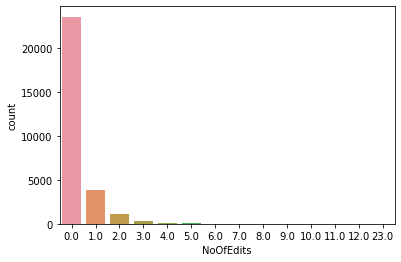

In [3]:
tags = pd.read_csv("data/SO/TagsCount.csv")
posts = pd.read_csv("data/SO/All4.csv").drop(["PostId"], axis=1)
posts["NoOfEdits"][posts["NoOfEdits"].isna()] = 0
posts["QLength"] = posts["Body"].str.len()
posts["T"] = posts["Body"].str.contains("<code>").astype(int)
posts["Y"] = posts["AnswerCount"].astype(bool).astype(int)
temp = posts["Tags"].str.split("><", expand=True)
for col in temp.columns:
    temp[col] = temp[col].str.replace("<", "")
    temp[col] = temp[col].str.replace(">", "")
    temp[col][~temp[col].isin(tags["tagname"])] = None
temp = (
    pd.concat([pd.get_dummies(temp[col]) for col in temp], axis=1)
    .groupby(lambda x: x, axis=1)
    .sum()
)
tag_cols = [f"Tag_{i}" for i in temp.columns]
# rel_columns = ["T", "QLength", "Reputation", "ViewCount", "NoOfEdits", "Y"]
rel_columns = ["T", "Reputation", "ViewCount", "NoOfEdits", "Y"]

posts[tag_cols] = temp.loc[(temp!=0).any(axis=1)].reset_index().drop(["index"],axis=1)
posts.drop(["Tags"], axis=1, inplace=True)
data = posts[[*rel_columns, *tag_cols]].dropna().reset_index(drop=True)
for col in rel_columns[1:-2]:
    q_2 = data[col].quantile(q=0.2)
    q_8 = data[col].quantile(q=0.8)
    IQR = q_8-q_2
    data = data[(data[col] >= q_2-IQR) & (data[col] <= q_8+IQR)]
data=data.reset_index(drop=True)
# g = sns.countplot(x="CommentCount", data=data)
# plt.savefig("CommentCount.png")
# plt.show()
# g = sns.histplot(x="QLength", data=data)
# plt.savefig("QLength.png")
# plt.show()
g = sns.histplot(x="Reputation", data=data)
plt.savefig("Reputation.png")
plt.show()
g = sns.histplot(x="ViewCount", data=data)
plt.savefig("ViewCount.png")
plt.show()
g = sns.countplot(x="NoOfEdits", data=data)
plt.savefig("NoOfEdits.png")
plt.show()
for col in rel_columns[1:-1]:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

### Histogram of Treatment and Outcome  variables

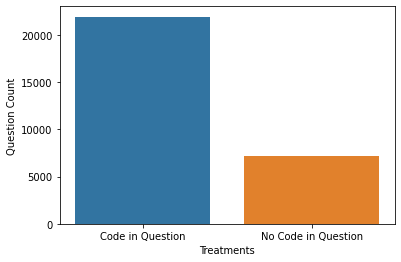

In [4]:
data_plot = data.copy()
data_plot['T'][data_plot['T']==0] = 'No Code in Question'
data_plot['T'][data_plot['T']==1] = 'Code in Question'
g = sns.countplot(x="T", data=data_plot)
g.set(xlabel="Treatments", ylabel="Question Count")
plt.savefig("Treatment.png")
ax = plt.plot()

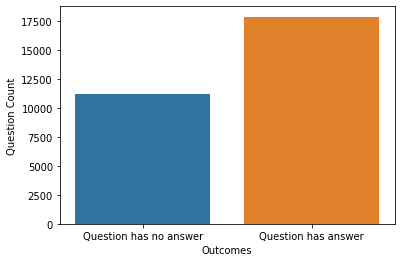

In [5]:
data_plot = data.copy()
data_plot['Y'][data_plot['Y']==0] = 'Question has no answer'
data_plot['Y'][data_plot['Y']==1] = 'Question has answer'
g = sns.countplot(x="Y", data=data_plot)
g.set(xlabel="Outcomes", ylabel="Question Count")
plt.savefig("Outcomes.png")
ax = plt.plot()

In [6]:
from scipy.spatial.distance import  hamming, jaccard
metrics = [hamming, jaccard]
for metric in metrics:
    print(f"The {metric.__name__} metric between T and Y is {metric(data['T'].to_numpy(),data['Y'].to_numpy())}")

The hamming metric between T and Y is 0.35878754553577563
The jaccard metric between T and Y is 0.41570438799076215


# Possible confounders:
1. <u>No. of comments</u>: asker could be asked to upload code and an answer could be discussed
2. <u>No. of Edits</u>: An edit could cause code to be inserted and an edit could create a clearer question that would be easier to answer
3. <u>No. of tags</u>: No. of tags could indicate a specific/broad question that could influence whether the question could have code. Also no. of tags increases exposure to the question, more people could see and possibly answer
4. <u>User experience</u>: Experience users are more likely to ask hard questions that are hard to answer, experience users possibly add more code to their questions.
5. <u>Length of question</u>: A longer question increases the chance of including code, also a longer question could decrease the chance people read the question and answer the question.

# Propensity score estimation

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay, brier_score_loss

In [8]:
def quality(model,X,y):
    X_train = X[: (len(X) // 5) * 4]
    y_train = y[: (len(X) // 5) * 4]
    X_test = X[(len(X) // 5) * 4 :]
    y_test = y[(len(X) // 5) * 4 :]
    fig,ax = plt.subplots()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RocCurveDisplay.from_estimator(model,X_test,y_test, ax=ax)
    # plt.savefig("AUROC graph.png")
    plt.show()
    compare = {"Model":[], "Accuracy":[], "Precision":[], "Recall":[], "F1":[], "Brier Score":[]}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    TP = np.sum((y_pred == y_test.flatten())[y_test.flatten() == 1])
    FP = np.sum((y_pred != y_test.flatten())[y_test.flatten() == 0])
    FN = np.sum((y_pred != y_test.flatten())[y_test.flatten() == 1])
    recall = TP/(TP+FP)
    precision = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)
    compare["Model"].append(str(model))
    compare["Accuracy"].append(sum(y_pred == y_test.flatten()) / len(y_test))
    compare["Precision"].append(TP/(TP+FP))
    compare["Recall"].append(TP/(TP+FN))
    compare["F1"].append(2*precision*recall/(precision+recall))
    compare["Brier Score"].append(brier_score_loss(y_test.flatten(), model.predict_proba(X_test)[:,1]))
    prop = pd.DataFrame(model.predict_proba(X))
    print("#########################################")
    display(pd.DataFrame.from_dict(compare))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


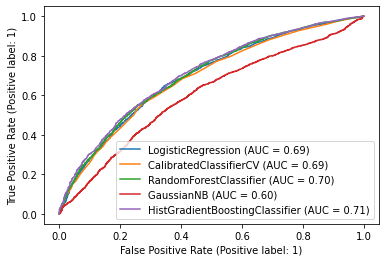

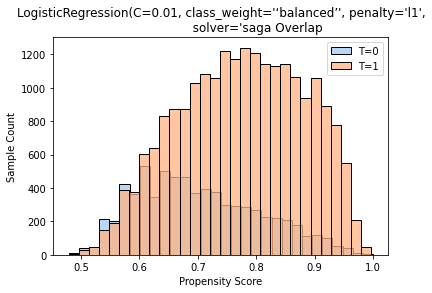

#########################################


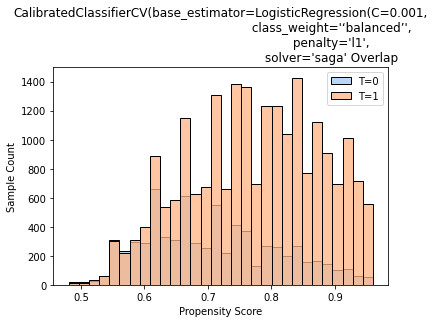

#########################################


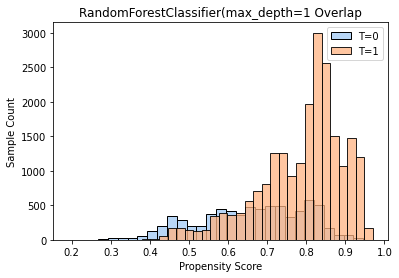

#########################################


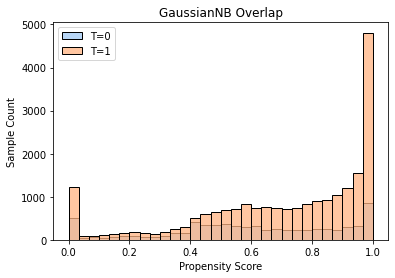

#########################################


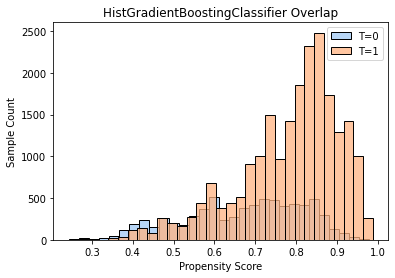

#########################################


,Model,Accuracy,Precision,Recall,F1,Brier Score
0,"LogisticRegression(C=0.01, class_weight='‘bala...",0.743044,0.743167,0.999538,0.852495,0.174992
1,CalibratedClassifierCV(base_estimator=Logistic...,0.743215,0.743294,0.999538,0.852579,0.176258
2,RandomForestClassifier(max_depth=15),0.751632,0.761300,0.969711,0.852959,0.172637
3,GaussianNB(),0.667812,0.771890,0.784740,0.778262,0.245884
4,HistGradientBoostingClassifier(),0.751288,0.764673,0.960925,0.851639,0.172152


In [9]:
models = [
    LogisticRegression(penalty='l1', solver='saga',class_weight='‘balanced’',C=0.01),
    CalibratedClassifierCV(base_estimator=LogisticRegression(penalty='l1', solver='saga',class_weight='‘balanced’',C=0.001)),
    RandomForestClassifier(max_depth=15),
    GaussianNB(),
    HistGradientBoostingClassifier()

]
X_cols = [col for col in data.columns if col not in ["T", "Y"]]
y_cols = ["T"]
data = data.sample(frac=1).reset_index(drop=True)
X = data[X_cols].to_numpy()
y = data[y_cols].to_numpy()
X_train = X[: (len(data) // 5) * 4]
y_train = y[: (len(data) // 5) * 4]
X_test = X[(len(data) // 5) * 4 :]
y_test = y[(len(data) // 5) * 4 :]
fig,ax = plt.subplots()
for model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RocCurveDisplay.from_estimator(model,X_test,y_test, ax=ax)
plt.savefig("AUROC graph.png")
plt.show()
compare = {"Model":[], "Accuracy":[], "Precision":[], "Recall":[], "F1":[], "Brier Score":[]}
for model in models:
    model.fit(X_train, y_train)
#     print(model.coef_)
    y_pred = model.predict(X_test)
    TP = np.sum((y_pred == y_test.flatten())[y_test.flatten() == 1])
    FP = np.sum((y_pred != y_test.flatten())[y_test.flatten() == 0])
    FN = np.sum((y_pred != y_test.flatten())[y_test.flatten() == 1])
    recall = TP/(TP+FP)
    precision = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)
    compare["Model"].append(str(model))
    compare["Accuracy"].append(sum(y_pred == y_test.flatten()) / len(y_test))
    compare["Precision"].append(TP/(TP+FP))
    compare["Recall"].append(TP/(TP+FN))
    compare["F1"].append(2*precision*recall/(precision+recall))
    compare["Brier Score"].append(brier_score_loss(y_test.flatten(), model.predict_proba(X_test)[:,1]))
    prop = pd.DataFrame(model.predict_proba(X))
    pallete = sns.color_palette("pastel", 2)
    for i, col in enumerate(prop.columns):
        g = sns.histplot(data=prop[1][data['T'] == i], color=pallete[i], label=f"T={col}",bins=30)
        g.set(xlabel='Propensity Score', ylabel='Sample Count')
    plt.title(str(model)[:-2]+" Overlap")
    plt.legend()
    plt.savefig(str(model).split("(")[0]+" Overlap.png")

    plt.show()
    print("#########################################")
pd.DataFrame.from_dict(compare)

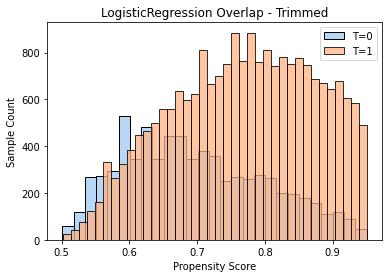

In [10]:
model = LogisticRegression(penalty='l1', solver='saga',class_weight='‘balanced’',C=0.01)
model.fit(X, y)
prop = pd.DataFrame(model.predict_proba(X))
prop = prop[(prop[1]>0.5)& (prop[1]<0.95)]
for i, col in enumerate(prop.columns):
    g = sns.histplot(data=prop[1][data['T'] == i], color=pallete[i], label=f"T={col}")
    g.set(xlabel='Propensity Score', ylabel='Sample Count')
plt.title(str(model).split("(")[0]+" Overlap - Trimmed")
plt.legend()
plt.savefig(str(model).split("(")[0]+" Overlap - trimmed.png")

plt.show()

# ATE Estimation
Since all models perform more or less the same, we chose to work with logistic regression for it's simplicity and efficiency


## Stabalized IPW Estimator

In [11]:
data_trimmed = data.iloc[prop.index].reset_index().drop(["index"], axis=1)
prop = prop.reset_index().drop(["index"],axis=1)
n = len(data_trimmed)
B = 100
treatments = [[1,0]]
for ate in treatments:
    data_ate = data_trimmed[data_trimmed['T'].isin(ate)]
    prop_ate = prop[ate].iloc[data_ate.index]
    ates = []
    for i in tqdm(range(B)):
        data_boot = data_ate.sample(frac=0.9)
        prop_boot = prop_ate.loc[data_boot.index]
        right_ATE = np.sum(data_boot['Y'][data_boot['T'] == ate[0]]/prop_boot[data_boot['T'] == ate[0]][ate[0]])
        left_ATE = np.sum(data_boot['Y'][data_boot['T'] == ate[1]]/prop_boot[data_boot['T'] == ate[1]][ate[1]])
        right_stab = 1/np.sum(data_boot['T']/prop_boot[ate[0]])
        left_stab = 1/np.sum((1-data_boot['T'])/prop_boot[ate[1]])
        ATE_boot = (right_stab * right_ATE) - (left_stab * left_ATE)
        ates.append(ATE_boot)
    print(f"The ATE CI for E[Y{ate[0]} - Y{ate[1]}] is : [{np.quantile(ates,0.025)}, {np.quantile(ates,0.975)}]")
    stable_ate_ci = [np.quantile(ates,0.025), np.quantile(ates,0.975)]
    stable_ate = np.mean(ates)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 96.48it/s]

The ATE CI for E[Y1 - Y0] is : [0.046726775787490536, 0.056401846851201455]


## IPW Estimator

In [12]:
data_trimmed = data.iloc[prop.index].reset_index().drop(["index"], axis=1)
prop = prop.reset_index().drop(["index"],axis=1)
n = len(data_trimmed)
B = 100
treatments = [[1,0]]
for ate in treatments:
    data_ate = data_trimmed[data_trimmed['T'].isin(ate)]
    prop_ate = prop[ate].iloc[data_ate.index]
    ates = []
    for i in tqdm(range(B)):
        data_boot = data_ate.sample(frac=0.9)
        n=len(data_boot)
        prop_boot = prop_ate.loc[data_boot.index]
        right_ATE = np.sum(data_boot['Y'][data_boot['T'] == ate[0]]/prop_boot[data_boot['T'] == ate[0]][ate[0]])
        left_ATE = np.sum(data_boot['Y'][data_boot['T'] == ate[1]]/prop_boot[data_boot['T'] == ate[1]][ate[1]])
        ATE_boot = right_ATE/n-left_ATE/n
        ates.append(ATE_boot)
    print(f"The ATE CI for E[Y{ate[0]} - Y{ate[1]}] is : [{np.quantile(ates,0.025)}, {np.quantile(ates,0.975)}]")
    ipw_ate_ci = [np.quantile(ates,0.025), np.quantile(ates,0.975)]
    ipw_ate = np.mean(ates)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 104.72it/s]

The ATE CI for E[Y1 - Y0] is : [0.13147436784617125, 0.1479508487971717]


## Propensity Score Matching 

In [13]:
for ate in treatments:
    data_ate = data_trimmed[data_trimmed["T"].isin(ate)]
    prop_ate = prop[ate].iloc[data_ate.index]
    ates = []
    for i in tqdm(range(B)):
        data_boot = data_ate.sample(frac=0.9)
        
        data_0 = data_boot[data_boot['T']==0]
        data_1 = data_boot[data_boot['T']==1]

        prop_0 = prop_ate.loc[data_0.index].to_numpy()
        prop_1 = prop_ate.loc[data_1.index].to_numpy()

        prob0 = np.expand_dims(prop_0[:,0],1)
        prob1 = np.expand_dims(prop_1[:,0],0)
        
        dist = np.abs(prob0 - prob1)
        
        closest_to_0 = np.argmin(dist,axis=1)
        closest_to_1 = np.argmin(dist,axis=0)

        data_0 = data_0.reset_index().drop(["index"],axis=1)
        data_1 = data_1.reset_index().drop(["index"],axis=1)
        
        closest_to_0 = data_1.loc[closest_to_0]['Y'].reset_index().drop(["index"],axis=1).to_numpy().flatten()
        closest_to_1 = data_0.loc[closest_to_1]['Y'].reset_index().drop(["index"],axis=1).to_numpy().flatten()

        ITE_0 = (closest_to_0 - data_0['Y'].to_numpy().flatten())
        ITE_1 = (data_1['Y'].to_numpy().flatten() - closest_to_1)
        
        ATE = (np.sum(ITE_0) + np.sum(ITE_1))/(len(ITE_0)+len(ITE_1))

        ates.append(ATE) 
#         break
    print(f"The ATE CI for E[Y{ate[0]} - Y{ate[1]}] is : [{np.quantile(ates,0.025)}, {np.quantile(ates,0.975)}]")
    prop_match_ci = [np.quantile(ates,0.025), np.quantile(ates,0.975)]

    prop_match = np.mean(ates)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]

The ATE CI for E[Y1 - Y0] is : [0.19183613609698866, 0.25834376222135313]


## Confouder Matching:
For continuous variables, distance is measured with euclidean distance, and it is weighted with a categorical similarity meteric (Sum of equal categorical values/ amount of possible categorical values) 

In [14]:
from sklearn.metrics.pairwise import euclidean_distances

B=100
for ate in treatments:
    data_ate = data_trimmed[data_trimmed["T"].isin(ate)]
    prop_ate = prop[ate].iloc[data_ate.index]
    ates = []
    for i in tqdm(range(B)):
        data_boot = data_ate.sample(frac=0.9)
        
        labels = data_boot["Y"]
        treatment = data_boot["T"]

        cat_features = data_boot[tag_cols]
        cont_features = data_boot[rel_columns[1:-1]]

        # Euclidian
        cont_not_treated = cont_features[treatment == 0].to_numpy()
        cont_treated = cont_features[treatment == 1].to_numpy()

        euclid_dist = euclidean_distances(cont_treated, cont_not_treated)

        # Categorial
        cat_not_treated = cat_features[treatment == 0].to_numpy()
        cat_treated = cat_features[treatment == 1].to_numpy()

        sim = []
        for treated in cat_treated:
            sim.append(np.sum(treated == cat_not_treated, axis=1)/len(tag_cols) )
        sim = 1 / np.stack(sim)

        closest_to_0 = np.argmin(euclid_dist * sim, axis=0)
        closest_to_1 = np.argmin(euclid_dist * sim, axis=1)

        labels_not_treated = labels[treatment == 0].reset_index().drop(["index"], axis=1)
        labels_treated = labels[treatment == 1].reset_index().drop(["index"], axis=1)
 
        ITE_0 = (labels_treated.loc[closest_to_0] - labels_not_treated).dropna()
        ITE_1 = (labels_treated - labels_not_treated.loc[closest_to_1]).dropna() 
        ATE = (np.sum(ITE_0) + np.sum(ITE_1))/(len(ITE_0)+len(ITE_1))
        ates.append(ATE) 
    print(f"The ATE CI for E[Y{ate[0]} - Y{ate[1]}] is : [{np.quantile(ates,0.025)}, {np.quantile(ates,0.975)}]")
    conf_match_ci = [np.quantile(ates,0.025), np.quantile(ates,0.975)]
    conf_match = np.mean(ates)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [32:04<00:00, 19.25s/it]

The ATE CI for E[Y1 - Y0] is : [-0.015040186517234981, 0.0578391137114854]


## T-Learner

In [15]:
models = [
    LogisticRegression,
    HistGradientBoostingClassifier ]

X_cols = [col for col in data_trimmed.columns if col not in ["T", "Y"]]
y_cols = ["Y"]
model_ates_t = {}
model_ates_ci_t = {}

for ate in treatments:
    for model in models:
        data_ate = data_trimmed[data_trimmed["T"].isin(ate)]
        prop_ate = prop[ate].iloc[data_ate.index]
        ates = []
        for i in tqdm(range(B)):
            m0 = model()
            m1 = model()
            data_boot = data_ate.sample(frac=0.9)
            prop_boot = prop_ate.loc[data_boot.index]
            X = data_boot[X_cols].to_numpy()
            y = data_boot[y_cols].to_numpy()
            X_0 = data_boot[data_boot["T"] == ate[0]][X_cols].to_numpy()
            X_1 = data_boot[data_boot["T"] == ate[1]][X_cols].to_numpy()
            y0 = data_boot[data_boot["T"] == ate[0]][y_cols].to_numpy()
            y1 = data_boot[data_boot["T"] == ate[1]][y_cols].to_numpy()
            m0.fit(X_0, y0)
            m1.fit(X_1, y1)
            m0_res = m0.predict(X)
            m1_res = m1.predict(X)
            g0 = m0_res 
            g1 = m1_res 
            ATE_boot = np.mean(g0-g1)
            ates.append(ATE_boot)
        print(f"The ATE CI for E[Y{ate[0]} - Y{ate[1]}] with model {str(model)} is : [{np.quantile(ates,0.025)}, {np.quantile(ates,0.975)}]")
        model_ates_ci_t[str(model)] = [np.quantile(ates,0.025), np.quantile(ates,0.975)]
        model_ates_t[str(model)] = np.mean(ates)
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s]


The ATE CI for E[Y1 - Y0] with model <class 'sklearn.linear_model._logistic.LogisticRegression'> is : [0.04049569808369183, 0.05121724677356277]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.21s/it]

The ATE CI for E[Y1 - Y0] with model <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'> is : [0.017771802894016427, 0.040860383261634714]


## S-Learner

In [16]:
X_cols = [col for col in data_trimmed.columns if col not in ["Y"]]
y_cols = ["Y"]

model_ates_s = {}
model_ates_ci_s = {}

for ate in treatments:
    for model in models:
        data_ate = data_trimmed[data_trimmed["T"].isin(ate)]
        prop_ate = prop[ate].iloc[data_ate.index]
        ates = []
        for i in tqdm(range(B)):
            m = model()
            data_boot = data_ate.sample(frac=0.9)
            prop_boot = prop_ate.loc[data_boot.index]
            X = data_boot[X_cols].to_numpy()
            y = data_boot[y_cols].to_numpy()
            m.fit(X, y)
            X_0 = data_boot[X_cols]
            X_1 = data_boot[X_cols]
            X_0['T'] = ate[0]
            X_1['T'] = ate[1]
            X_0 = X_0.to_numpy()
            X_1 = X_1.to_numpy()
            m0_res = m.predict(X_0)
            m1_res = m.predict(X_1)
            g0 = m0_res 
            g1 = m1_res 
            ATE_boot = np.mean(g0-g1)
            ates.append(ATE_boot)
        print(f"The ATE CI for E[Y{ate[0]} - Y{ate[1]}] with model {model} is : [{np.quantile(ates,0.025)}, {np.quantile(ates,0.975)}]")
        model_ates_ci_s[str(model)] = [np.quantile(ates,0.025), np.quantile(ates,0.975)]

        model_ates_s[str(model)] = np.mean(ates)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


The ATE CI for E[Y1 - Y0] with model <class 'sklearn.linear_model._logistic.LogisticRegression'> is : [0.053108134532655456, 0.06285490809542432]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]

The ATE CI for E[Y1 - Y0] with model <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'> is : [0.0059034024247164646, 0.024328314430973778]


##  Graphics

In [21]:
import plotly.graph_objects as go

# get the data for plots
eta_estimators = [
    stable_ate,
    ipw_ate,
    prop_match,
    conf_match,
    *model_ates_t.values(),
    *model_ates_s.values(),
]
all_CIs = [
    stable_ate_ci,
    ipw_ate_ci,
    prop_match_ci,
    conf_match_ci,
    *model_ates_ci_t.values(),
    *model_ates_ci_s.values(),
]

colors = [
    "#636EFA",
    "#636EFA",
    "#EF553B",
    "#EF553B",
    "#00CC96",
    "#00CC96",
    "#F740FF",
    "#F740FF",
]
texts = [
    "Stabilized IPW",
    "IPW",
    "Propensity Score Matching",
    "Confounder Matching",
    "T-learner Logistic Regression",
    "T-learner Gradient Boosted Random Forest",
    "S-learner Logistic Regression",
    "S-learner Gradient Boosted Random Forest",
]

# plot the data
# layout = go.Layout(title = f'ATE point estimators and CIs (vertical line is the point estimator, rectangle is the CI)',yaxis = go.layout.YAxis(showticklabels=False))
layout = go.Layout()
fig = go.Figure(layout=layout)
# Set axes properties
min_val, max_val = all_CIs[0][0], all_CIs[0][0]
for idx_estimators, estimators in enumerate(eta_estimators):
    eta_value = estimators
    CI_left = all_CIs[idx_estimators][0]
    CI_right = all_CIs[idx_estimators][1]

    if CI_left < min_val:
        min_val = CI_left
    if CI_right > max_val:
        max_val = CI_right

    # Rectangle
    fig.add_shape(
        type="rect",
        x0=CI_left,
        y0=idx_estimators - 0.2,
        x1=CI_right,
        y1=idx_estimators + 0.2,
        line=dict(color="black", width=1),
        fillcolor=colors[idx_estimators],
    )

    # line
    fig.add_shape(
        type="line",
        x0=eta_value,
        y0=idx_estimators - 0.25,
        x1=eta_value,
        y1=idx_estimators + 0.25,
        line=dict(color="black"),
        fillcolor=colors[idx_estimators],
    )

    # text
    fig.add_trace(
        go.Scatter(
            x=[(CI_right + CI_left) / 2],
            y=[idx_estimators + 0.35],
            text=[texts[idx_estimators]],
            mode="text",
            showlegend=False,
        )
    )

dif = max_val - min_val
fig.update_xaxes(range=[min_val - 0.1 * dif, max_val + 0.1 * dif], showgrid=False)
fig.update_yaxes(range=[-0.5, 8])
fig.show()

In [18]:
eta_estimators

[0.05160519990485857,
 0.13796353548601795,
 0.22399296050058662,
 0.021147829559062914,
 0.045956980836918265,
 0.028045365662886193,
 0.05761986703167774,
 0.012870942510754789]

In [22]:
all_CIs

[[0.046726775787490536, 0.056401846851201455],
 [0.13147436784617125, 0.1479508487971717],
 [0.19183613609698866, 0.25834376222135313],
 [-0.015040186517234981, 0.0578391137114854],
 [0.04049569808369183, 0.05121724677356277],
 [0.017771802894016427, 0.040860383261634714],
 [0.053108134532655456, 0.06285490809542432],
 [0.0059034024247164646, 0.024328314430973778]]